# Assignment

In [6]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *


size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [7]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)
S,X,allowed_a=env.Initialise_game()

SARSA IMPLEMENTATION WITH 1 HIDDEN LAYER

In [8]:
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES

np.random.seed(1000)

## INITALISE YOUR NEURAL NETWORK...

W1 = np.random.randn(N_h, N_in) * np.sqrt(1/N_in)
W2 = np.random.randn(N_a, N_h) * np.sqrt(1/N_h)

biasW1 = np.zeros((N_h,))
biasW2 = np.zeros((N_a,))


# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 


#Caching of Reward and Moves per game for EMA plot
Reward_cached_S = np.zeros([N_episodes, 1])
Num_moves_cached_S = np.zeros([N_episodes, 1])

a_agent_cached = 100 # Set to abnormally high number to not be possible action

#FOR VIEWING PROGRESS
wins = 0                                   
win_rate_history = []



# TRAINING LOOP BONE STRUCTURE...
# I WROTE FOR YOU A RANDOM AGENT (THE RANDOM AGENT WILL BE SLOWER TO GIVE CHECKMATE THAN AN OPTIMISED ONE, 
# SO DON'T GET CONCERNED BY THE TIME IT TAKES), CHANGE WITH YOURS ..

def EpsilonGreedy_Policy(output_out, epsilon, allowed_a):

  a_indices = np.where(allowed_a == 1)[0]

  if np.random.uniform(0, 1) < epsilon:
    a_agent = a_indices[np.random.randint(len(a_indices))]

  else:
    output_values = output_out[a_indices]
    a_agent = a_indices[np.argmax(output_values)]

  return a_agent  

def Forward_prop(X, W1, W2, biasW1, biasW2):

    hidden_in = np.dot(W1, X) + biasW1
    #ReLU
    hidden_out = (hidden_in > 0) * hidden_in
    #Not used sigmoid activation function
    #hidden_out = 1/(1+np.exp(-hidden_in))

    output_in = np.dot(W2, hidden_out) + biasW2
    output_out = (output_in > 0) * output_in

    return output_out, output_in, hidden_out, hidden_in, 


def Back_prop(X, output_in, hidden_out, hidden_in, W2, TD_error, Q_mask):

    #BACKPROPAGATION: OUTPUT to HIDDEN
    # Multiply error with Q_mask
    delta2 = TD_error * Q_mask
    #Apply ReLU derivative to output_in   
    relu_output = np.where(output_in > 0, 1, 0)
    delta2 *= relu_output
    #Calculation of Gradients
    dW2 = np.outer(delta2, hidden_out)
    dbiasW2 = delta2.copy()


    #BACKPROPAGATION: HIDDEN to INPUT
    relu_hidden = np.where(hidden_in > 0, 1, 0)
    delta1 = relu_hidden * np.dot(W2.T, delta2)
    dW1 = np.outer(delta1, X)
    dbiasW1 = delta1.copy()


    return dW1, dW2, dbiasW1, dbiasW2



for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
                           
    while Done==0:                           ## START THE EPISODE
            
        ## THIS IS A RANDOM AGENT, CHANGE IT...
    
        output_out, output_in, hidden_out, hidden_in = Forward_prop(X, W1, W2, biasW1, biasW2)


        #ENSURING AGENT USED TO UPDATE Q VALUES IS SAME AS THE ACTUAL ONE NEXT ONE SELECTED IF GAME IS NOT OVER (SARSA EXCLUSIVE)
        if a_agent_cached != 100: 

            a_agent = a_agent_cached
        else:   

            a_agent = EpsilonGreedy_Policy(output_out, epsilon_f, allowed_a)
        
        
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)       

        Q_value = output_out[a_agent]
        
        # ONE HOT ENCODING OF Q_VALUE IN ARRAY OF SIZE OF NN OUTPUT
        Q_mask = np.eye(32)[a_agent]

        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            
            TD_error = R - Q_value
            
            delta2 = TD_error *output_out    
                
            dW1, dW2, dbiasW1, dbiasW2 = Back_prop(X, output_in, hidden_out, hidden_in, W2, TD_error, Q_mask)
                  
            W1 += eta * dW1
            W2 += eta * dW2
            biasW1 += eta * dbiasW1
            biasW2 += eta * dbiasW2

            if R == 1:
                wins += 1  

            Reward_cached_S[n] = R
            Num_moves_cached_S[n] = i
            a_agent_cached = 100

            break
        

        i += 1
        
        win_rate = wins / (n+1)
        win_rate_history.append(win_rate)
        
        if (n+1) % 100 == 0:
            print(f"Episode: {n+1}/{N_episodes}, Win Rate: {win_rate}")
    
        #FORWARD PROPAGATION AGAIN TO ATTAIN FUTURE VALUES
        output_out_next, output_in_next, hidden_out_next, hidden_in_next = Forward_prop(X_next, W1, W2, biasW1, biasW2)
        
        a_agent_next = EpsilonGreedy_Policy(output_out_next, epsilon_f, allowed_a_next)


        #SARSA adaptation of Bellman eqaution  
        Q_next = R + gamma * output_out_next[a_agent_next] 
        TD_error = Q_next - Q_value 


        dW1, dW2, dbiasW1, dbiasW2 = Back_prop(X, output_in, hidden_out, hidden_in, W2, TD_error, Q_mask)
        
        #UPDATING OF WEIGHTS + BIASES
        W1 += eta * dW1
        W2 += eta * dW2
        biasW1 += eta * dbiasW1
        biasW2 += eta * dbiasW2            
        
        #ASSIGNING OF NEW VARIABLES
        X = X_next
        S = S_next
        allowed_a = allowed_a_next
        a_agent_cached = a_agent_next

Episode: 100/100000, Win Rate: 0.2
Episode: 100/100000, Win Rate: 0.2
Episode: 100/100000, Win Rate: 0.2
Episode: 100/100000, Win Rate: 0.2
Episode: 100/100000, Win Rate: 0.2
Episode: 100/100000, Win Rate: 0.2
Episode: 100/100000, Win Rate: 0.2
Episode: 100/100000, Win Rate: 0.2
Episode: 100/100000, Win Rate: 0.2
Episode: 100/100000, Win Rate: 0.2
Episode: 100/100000, Win Rate: 0.2
Episode: 100/100000, Win Rate: 0.2
Episode: 100/100000, Win Rate: 0.2
Episode: 200/100000, Win Rate: 0.175
Episode: 200/100000, Win Rate: 0.175
Episode: 200/100000, Win Rate: 0.175
Episode: 200/100000, Win Rate: 0.175
Episode: 200/100000, Win Rate: 0.175
Episode: 200/100000, Win Rate: 0.175
Episode: 500/100000, Win Rate: 0.248
Episode: 500/100000, Win Rate: 0.248
Episode: 500/100000, Win Rate: 0.248
Episode: 500/100000, Win Rate: 0.248
Episode: 500/100000, Win Rate: 0.248
Episode: 500/100000, Win Rate: 0.248
Episode: 500/100000, Win Rate: 0.248
Episode: 500/100000, Win Rate: 0.248
Episode: 500/100000, Win Ra

PLOTTING SARSA

0.92215
3.18352


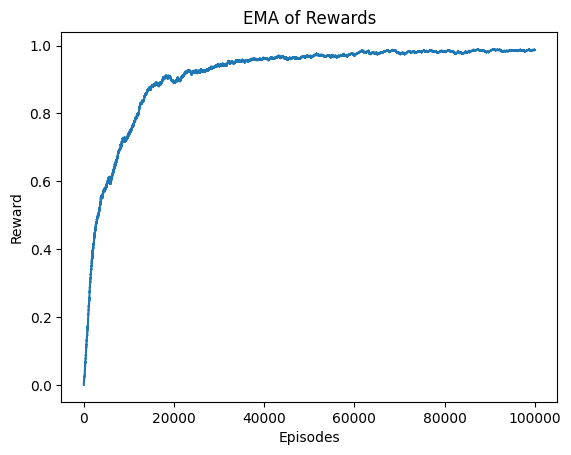

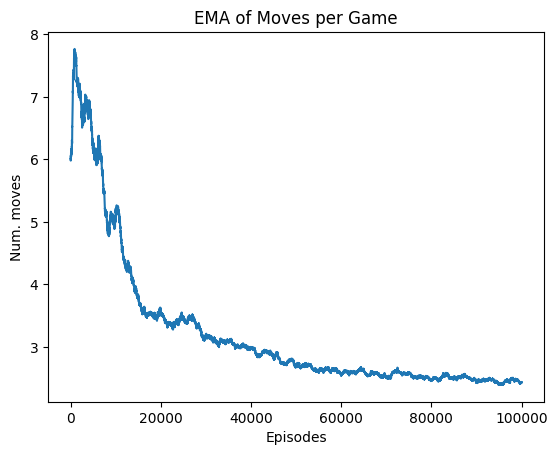

In [11]:
print(np.mean(Reward_cached_S))
print(np.mean(Num_moves_cached_S))

def ema(data, alpha):
    ema = np.zeros(data.shape)
    ema[0] = data[0]
    for i in range(1,len(data)):
        ema[i] = alpha * data[i] + (1-alpha) * ema[i-1]
    return ema

alpha = 100 / N_episodes
EMA_Reward_S = ema(Reward_cached_S, alpha)
EMA_Moves_S = ema(Num_moves_cached_S, alpha)

plt.plot(EMA_Reward_S)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('EMA of Rewards')
plt.savefig('figures/EMA_Reward_SARSA.png', dpi = 500)
plt.show()

plt.plot(EMA_Moves_S)
plt.xlabel('Episodes')
plt.ylabel('Num. moves')
plt.title('EMA of Moves per Game')
plt.savefig('figures/EMA_Moves_SARSA.png', dpi = 500)
plt.show()

Q-LEARNING IMPLEMENTATION WITH 1 HIDDEN LAYER

In [12]:
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES

np.random.seed(1000)

## INITALISE YOUR NEURAL NETWORK...

W1 = np.random.randn(N_h, N_in) * np.sqrt(1/N_in)
W2 = np.random.randn(N_a, N_h) * np.sqrt(1/N_h)

biasW1 = np.zeros((N_h,))
biasW2 = np.zeros((N_a,))


# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.035      # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 


#Caching of Reward and Moves per game for plotting EMA
Reward_cached_Q = np.zeros([N_episodes, 1])
Num_moves_cached_Q = np.zeros([N_episodes, 1])


#FOR VIEWING PROGRESS
wins = 0                                   
win_rate_history = []


# TRAINING LOOP BONE STRUCTURE...
# I WROTE FOR YOU A RANDOM AGENT (THE RANDOM AGENT WILL BE SLOWER TO GIVE CHECKMATE THAN AN OPTIMISED ONE, 
# SO DON'T GET CONCERNED BY THE TIME IT TAKES), CHANGE WITH YOURS ..

def EpsilonGreedy_Policy(output_out, epsilon, allowed_a):

  a_indices = np.where(allowed_a == 1)[0]

  if np.random.uniform(0, 1) < epsilon:
    a_agent = a_indices[np.random.randint(len(a_indices))]

  else:
    output_values = output_out[a_indices]
    a_agent = a_indices[np.argmax(output_values)]

  return a_agent  

def Forward_prop(X, W1, W2, biasW1, biasW2):

    hidden_in = np.dot(W1, X) + biasW1
    #ReLU
    hidden_out = (hidden_in > 0) * hidden_in
    #Not used sigmoid activation function
    #hidden_out = 1/(1+np.exp(-hidden_in))


    output_in = np.dot(W2, hidden_out) + biasW2
    output_out = (output_in > 0) * output_in

    return output_out, output_in, hidden_out, hidden_in, 


def Back_prop(X, output_in, hidden_out, hidden_in, W2, TD_error, Q_mask):

    #BACKPROPAGATION: OUTPUT -> HIDDEN
    # Multiply error with Q_mask
    delta2 = TD_error * Q_mask
    #Apply ReLU derivative to output_in   
    relu_output = np.where(output_in > 0, 1, 0)
    delta2 *= relu_output
    #Calculation of Gradients
    dW2 = np.outer(delta2, hidden_out)
    dbiasW2 = delta2.copy()


    #BACKPROPAGATION: HIDDEN -> INPUT
    relu_hidden = np.where(hidden_in > 0, 1, 0)
    delta1 = relu_hidden * np.dot(W2.T, delta2)
    dW1 = np.outer(delta1, X)
    dbiasW1 = delta1.copy()


    return dW1, dW2, dbiasW1, dbiasW2



for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
                           
    while Done==0:                           ## START THE EPISODE
            
        ## THIS IS A RANDOM AGENT, CHANGE IT...
    
        output_out, output_in, hidden_out, hidden_in = Forward_prop(X, W1, W2, biasW1, biasW2)


        #ENSURING AGENT USED TO UPDATE Q VALUES IS SAME AS THE ACTUAL ONE NEXT ONE SELECTED IF GAME IS NOT OVER (SARSA EXCLUSIVE)

        a_agent = EpsilonGreedy_Policy(output_out, epsilon_f, allowed_a)
        
        
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)       

        Q_value = output_out[a_agent]
        
        # ONE HOT ENCODING OF Q_VALUE IN ARRAY OF SIZE OF NN OUTPUT
        Q_mask = np.eye(32)[a_agent]

        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            
            TD_error = R - Q_value
            
            delta2 = TD_error *output_out 
                
            dW1, dW2, dbiasW1, dbiasW2 = Back_prop(X, output_in, hidden_out, hidden_in, W2, TD_error, Q_mask)
        
            W1 += eta * dW1
            W2 += eta * dW2
            biasW1 += eta * dbiasW1
            biasW2 += eta * dbiasW2

            if R == 1:
                wins += 1     

            Reward_cached_Q[n] = R
            Num_moves_cached_Q[n] = i

            break
        

        i += 1
        
        win_rate = wins / (n+1)
        win_rate_history.append(win_rate)
        
        if (n+1) % 100 == 0:
            print(f"Episode: {n+1}/{N_episodes}, Win Rate: {win_rate}")
    
        #FORWARD PROPAGATION AGAIN TO ATTAIN FUTURE VALUES
        output_out_next, output_in_next, hidden_out_next, hidden_in_next = Forward_prop(X_next, W1, W2, biasW1, biasW2)
        
        a_agent_next = EpsilonGreedy_Policy(output_out_next, epsilon_f, allowed_a_next)


        #Bellman equation
        #Max valid Q-value in next state
        valid = np.where(allowed_a_next==1)[0]
        TD_error = R + gamma * np.max(output_out_next[valid]) - Q_value 


        dW1, dW2, dbiasW1, dbiasW2 = Back_prop(X, output_in, hidden_out, hidden_in, W2, TD_error, Q_mask)
        
        #UPDATING OF WEIGHTS + BIASES
        W1 += eta * dW1
        W2 += eta * dW2
        biasW1 += eta * dbiasW1
        biasW2 += eta * dbiasW2            
        
        #ASSIGNING OF NEW VARIABLES
        X = X_next
        S = S_next
        allowed_a = allowed_a_next

Episode: 100/100000, Win Rate: 0.45
Episode: 200/100000, Win Rate: 0.485
Episode: 200/100000, Win Rate: 0.485
Episode: 300/100000, Win Rate: 0.5566666666666666
Episode: 300/100000, Win Rate: 0.5566666666666666
Episode: 300/100000, Win Rate: 0.5566666666666666
Episode: 300/100000, Win Rate: 0.5566666666666666
Episode: 400/100000, Win Rate: 0.58
Episode: 400/100000, Win Rate: 0.58
Episode: 400/100000, Win Rate: 0.58
Episode: 400/100000, Win Rate: 0.58
Episode: 400/100000, Win Rate: 0.58
Episode: 400/100000, Win Rate: 0.58
Episode: 500/100000, Win Rate: 0.596
Episode: 500/100000, Win Rate: 0.596
Episode: 500/100000, Win Rate: 0.596
Episode: 500/100000, Win Rate: 0.596
Episode: 500/100000, Win Rate: 0.596
Episode: 500/100000, Win Rate: 0.596
Episode: 500/100000, Win Rate: 0.596
Episode: 500/100000, Win Rate: 0.596
Episode: 500/100000, Win Rate: 0.596
Episode: 500/100000, Win Rate: 0.596
Episode: 500/100000, Win Rate: 0.596
Episode: 500/100000, Win Rate: 0.596
Episode: 500/100000, Win Rate:

0.96884
2.31662


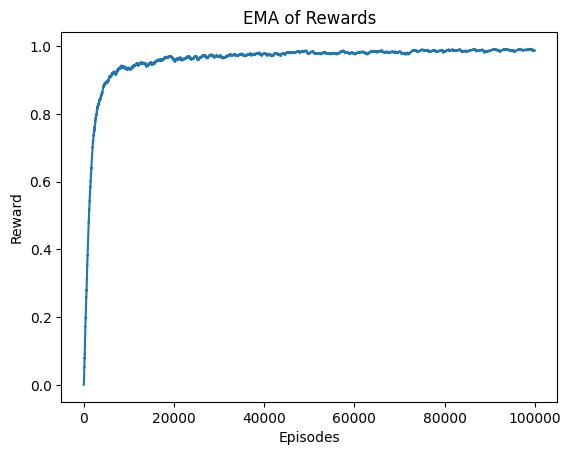

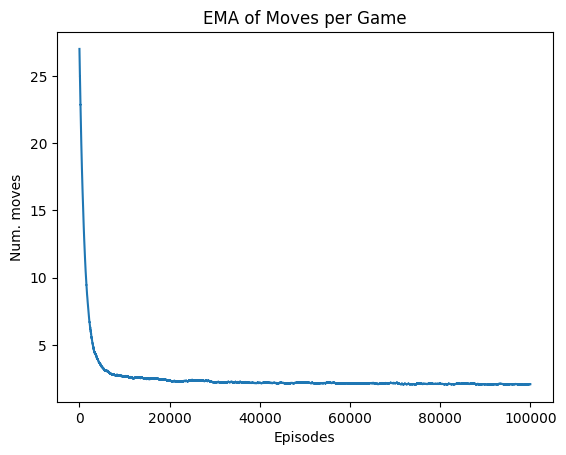

In [14]:
print(np.mean(Reward_cached_Q))
print(np.mean(Num_moves_cached_Q))

EMA_Reward_Q = ema(Reward_cached_Q, alpha)
EMA_Moves_Q = ema(Num_moves_cached_Q, alpha)

plt.plot(EMA_Reward_Q)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('EMA of Rewards')
plt.savefig('figures/EMA_Reward_Q1.png', dpi = 500)
plt.show()

plt.plot(EMA_Moves_Q)
plt.xlabel('Episodes')
plt.ylabel('Num. moves')
plt.title('EMA of Moves per Game')
plt.savefig('figures/EMA_Moves_Q1.png', dpi = 500)
plt.show()

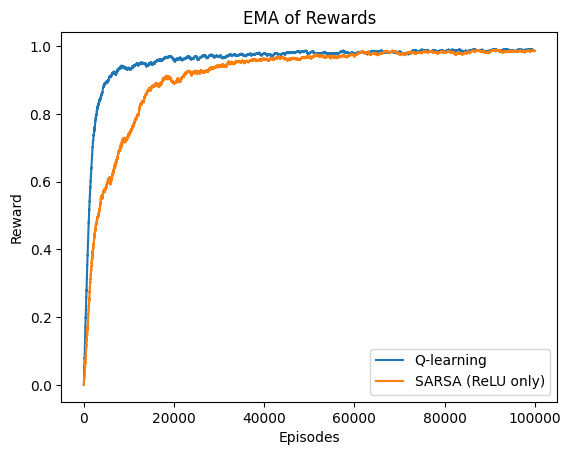

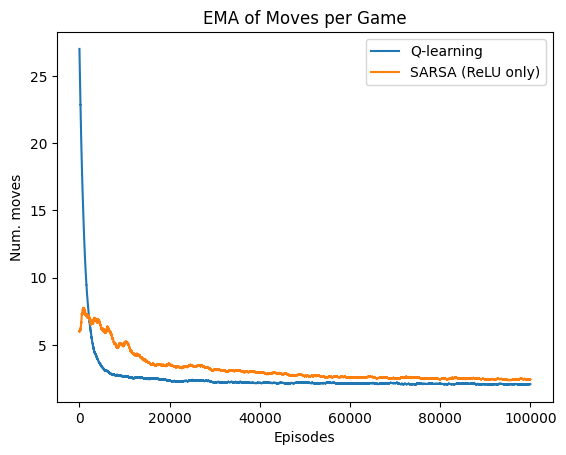

In [51]:

plt.plot(EMA_Reward_Q, label='Q-learning')
plt.plot(EMA_Reward_S, label='SARSA (ReLU only)')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('EMA of Rewards')
plt.legend()  # Display the legend showing the labels
plt.savefig('figures/EMA_Rewards_Combined.png', dpi=500)
plt.show()

plt.plot(EMA_Moves_Q, label='Q-learning')
plt.plot(EMA_Moves_S, label='SARSA (ReLU only)')
plt.xlabel('Episodes')
plt.ylabel('Num. moves')
plt.title('EMA of Moves per Game')
plt.legend()  # Display the legend showing the labels
plt.savefig('figures/EMA_Moves_Combined.png', dpi=500)
plt.show()

SARSA WITH 2 HIDDEN LAYERS

In [15]:
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES
N_h2=200
np.random.seed(1000)

## INITALISE YOUR NEURAL NETWORK...

W1 = np.random.randn(N_h, N_in) * np.sqrt(1/N_in)
W2 = np.random.randn(N_h2, N_h) * np.sqrt(1/N_h)
W3 = np.random.randn(N_a, N_h2) * np.sqrt(1/N_h2)

biasW1 = np.zeros((N_h,))
biasW2 = np.zeros((N_h2,))
biasW3 = np.zeros((N_a,))


# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 


#Caching of Reward and Moves per game for EMA plot
Reward_cached_S2 = np.zeros([N_episodes, 1])
Num_moves_cached_S2 = np.zeros([N_episodes, 1])

a_agent_cached = 100 # Set to abnormally high number to not be possible action

#FOR VIEWING PROGRESS
wins = 0                                   
win_rate_history = []



# TRAINING LOOP BONE STRUCTURE...
# I WROTE FOR YOU A RANDOM AGENT (THE RANDOM AGENT WILL BE SLOWER TO GIVE CHECKMATE THAN AN OPTIMISED ONE, 
# SO DON'T GET CONCERNED BY THE TIME IT TAKES), CHANGE WITH YOURS ..

def EpsilonGreedy_Policy(output_out, epsilon, allowed_a):

  a_indices = np.where(allowed_a == 1)[0]

  if np.random.uniform(0, 1) < epsilon:
    a_agent = a_indices[np.random.randint(len(a_indices))]

  else:
    output_values = output_out[a_indices]
    a_agent = a_indices[np.argmax(output_values)]

  return a_agent  

def Forward_prop(X, W1, W2, W3, biasW1, biasW2, biasW3):

    hidden_in = np.dot(W1, X) + biasW1
    #ReLU
    hidden_out = (hidden_in > 0) * hidden_in
    #Not used sigmoid activation function
    #hidden_out = 1/(1+np.exp(-hidden_in))

    hidden2_in = np.dot(W2, hidden_out) + biasW2
    #ReLU
    hidden2_out = (hidden2_in > 0) * hidden2_in   

    output_in = np.dot(W3, hidden2_out) + biasW3
    output_out = (output_in > 0) * output_in

    return output_out, output_in, hidden_out, hidden_in, hidden2_in, hidden2_out


def Back_prop(X, output_in, hidden_out, hidden_in, hidden2_in, hidden2_out, W2, W3, TD_error, Q_mask):

    #BACKPROPAGATION: OUTPUT -> HIDDEN2
    # Multiply error with Q_mask
    delta3 = TD_error * Q_mask
    #Apply ReLU derivative to output_in   
    relu_output = np.where(output_in > 0, 1, 0)
    delta3 *= relu_output
    #Calculation of Gradients
    dW3 = np.outer(delta3, hidden2_out)
    dbiasW3 = delta3.copy()

    #BACKPROPAGATION: HIDDEN2 -> HIDDEN
    delta2 = TD_error * Q_mask
    #Apply ReLU derivative to output_in   
    relu_hidden2 = np.where(hidden2_in > 0, 1, 0)
    delta2 = relu_hidden2 * np.dot(W3.T, delta2)
    #Calculation of Gradients
    dW2 = np.outer(delta2, hidden_out)
    dbiasW2 = delta2.copy()

    #BACKPROPAGATION: HIDDEN -> INPUT
    relu_hidden = np.where(hidden_in > 0, 1, 0)
    delta1 = relu_hidden * np.dot(W2.T, delta2)
    dW1 = np.outer(delta1, X)
    dbiasW1 = delta1.copy()


    return dW1, dW2, dW3, dbiasW1, dbiasW2, dbiasW3



for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
                           
    while Done==0:                           ## START THE EPISODE
            
        ## THIS IS A RANDOM AGENT, CHANGE IT...
    
        output_out, output_in, hidden_out, hidden_in, hidden2_in, hidden2_out = Forward_prop(X, W1, W2, W3, biasW1, biasW2, biasW3)


        #ENSURING AGENT USED TO UPDATE Q VALUES IS SAME AS THE ACTUAL ONE NEXT ONE SELECTED IF GAME IS NOT OVER (SARSA EXCLUSIVE)
        if a_agent_cached != 100: 

            a_agent = a_agent_cached
        else:   

            a_agent = EpsilonGreedy_Policy(output_out, epsilon_f, allowed_a)
        
        
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)       

        Q_value = output_out[a_agent]
        
        # ONE HOT ENCODING OF Q_VALUE IN ARRAY OF SIZE OF NN OUTPUT
        Q_mask = np.eye(32)[a_agent]

        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            
            TD_error = R - Q_value
            
            delta2 = TD_error *output_out    
                
            dW1, dW2, dW3, dbiasW1, dbiasW2, dbiasW3 = Back_prop(X, output_in, hidden_out, hidden_in, hidden2_in, hidden2_out, W2, W3, TD_error, Q_mask)
                  
            W1 += eta * dW1
            W2 += eta * dW2
            W3 += eta * dW3
            biasW1 += eta * dbiasW1
            biasW2 += eta * dbiasW2
            biasW3 += eta * dbiasW3

            if R == 1:
                wins += 1  

            Reward_cached_S2[n] = R
            Num_moves_cached_S2[n] = i
            a_agent_cached = 100

            break
        

        i += 1
        
        win_rate = wins / (n+1)
        win_rate_history.append(win_rate)
        
        if (n+1) % 100 == 0:
            print(f"Episode: {n+1}/{N_episodes}, Win Rate: {win_rate}")
    
        #FORWARD PROPAGATION AGAIN TO ATTAIN FUTURE VALUES
        output_out_next, output_in_next, hidden_out_next, hidden_in_next, hidden2_out_next, hidden2_in_next = Forward_prop(X_next, W1, W2, W3, biasW1, biasW2, biasW3)
        
        a_agent_next = EpsilonGreedy_Policy(output_out_next, epsilon_f, allowed_a_next)


        #SARSA adaptation of Bellman eqaution  
        Q_next = R + gamma * output_out_next[a_agent_next] 
        TD_error = Q_next - Q_value 


        dW1, dW2, dW3, dbiasW1, dbiasW2, dbiasW3 = Back_prop(X, output_in, hidden_out, hidden_in, hidden2_in, hidden2_out, W2, W3, TD_error, Q_mask)
        
        #UPDATING OF WEIGHTS + BIASES
        W1 += eta * dW1
        W2 += eta * dW2
        W3 += eta * dW3
        biasW1 += eta * dbiasW1
        biasW2 += eta * dbiasW2
        biasW3 += eta * dbiasW3         
        
        #ASSIGNING OF NEW VARIABLES
        X = X_next
        S = S_next
        allowed_a = allowed_a_next
        a_agent_cached = a_agent_next

Episode: 100/100000, Win Rate: 0.33
Episode: 100/100000, Win Rate: 0.33
Episode: 100/100000, Win Rate: 0.33
Episode: 100/100000, Win Rate: 0.33
Episode: 100/100000, Win Rate: 0.33
Episode: 100/100000, Win Rate: 0.33
Episode: 100/100000, Win Rate: 0.33
Episode: 100/100000, Win Rate: 0.33
Episode: 100/100000, Win Rate: 0.33
Episode: 100/100000, Win Rate: 0.33
Episode: 100/100000, Win Rate: 0.33
Episode: 100/100000, Win Rate: 0.33
Episode: 100/100000, Win Rate: 0.33
Episode: 100/100000, Win Rate: 0.33
Episode: 100/100000, Win Rate: 0.33
Episode: 100/100000, Win Rate: 0.33
Episode: 100/100000, Win Rate: 0.33
Episode: 100/100000, Win Rate: 0.33
Episode: 100/100000, Win Rate: 0.33
Episode: 100/100000, Win Rate: 0.33
Episode: 100/100000, Win Rate: 0.33
Episode: 200/100000, Win Rate: 0.305
Episode: 200/100000, Win Rate: 0.305
Episode: 200/100000, Win Rate: 0.305
Episode: 200/100000, Win Rate: 0.305
Episode: 200/100000, Win Rate: 0.305
Episode: 200/100000, Win Rate: 0.305
Episode: 200/100000, W

Q-LEARNING WITH 2 HIDDEN LAYERS

In [46]:
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES

np.random.seed(1000)

## INITALISE YOUR NEURAL NETWORK...

W1 = np.random.randn(N_h, N_in) * np.sqrt(1/N_in)
W2 = np.random.randn(N_h2, N_h) * np.sqrt(1/N_h)
W3 = np.random.randn(N_a, N_h2) * np.sqrt(1/N_h2)

biasW1 = np.zeros((N_h,))
biasW2 = np.zeros((N_h2,))
biasW3 = np.zeros((N_a,))


# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.035      # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 


#Caching of Reward and Moves per game for plotting EMA
Reward_cached_Q2 = np.zeros([N_episodes, 1])
Num_moves_cached_Q2 = np.zeros([N_episodes, 1])


#FOR VIEWING PROGRESS
wins = 0                                   
win_rate_history = []


# TRAINING LOOP BONE STRUCTURE...
# I WROTE FOR YOU A RANDOM AGENT (THE RANDOM AGENT WILL BE SLOWER TO GIVE CHECKMATE THAN AN OPTIMISED ONE, 
# SO DON'T GET CONCERNED BY THE TIME IT TAKES), CHANGE WITH YOURS ..

def EpsilonGreedy_Policy(output_out, epsilon, allowed_a):

  a_indices = np.where(allowed_a == 1)[0]

  if np.random.uniform(0, 1) < epsilon:
    a_agent = a_indices[np.random.randint(len(a_indices))]

  else:
    output_values = output_out[a_indices]
    a_agent = a_indices[np.argmax(output_values)]

  return a_agent  

def Forward_prop(X, W1, W2, W3, biasW1, biasW2, biasW3):

    hidden_in = np.dot(W1, X) + biasW1
    #ReLU
    hidden_out = (hidden_in > 0) * hidden_in
    #Not used sigmoid activation function
    #hidden_out = 1/(1+np.exp(-hidden_in))

    hidden2_in = np.dot(W2, hidden_out) + biasW2
    #ReLU
    hidden2_out = (hidden2_in > 0) * hidden2_in   

    output_in = np.dot(W3, hidden2_out) + biasW3
    output_out = (output_in > 0) * output_in

    return output_out, output_in, hidden_out, hidden_in, hidden2_in, hidden2_out


def Back_prop(X, output_in, hidden_out, hidden_in, hidden2_in, hidden2_out, W2, W3, TD_error, Q_mask):

    #BACKPROPAGATION: OUTPUT -> HIDDEN2
    # Multiply error with Q_mask
    delta3 = TD_error * Q_mask
    #Apply ReLU derivative to output_in   
    relu_output = np.where(output_in > 0, 1, 0)
    delta3 *= relu_output
    #Calculation of Gradients
    dW3 = np.outer(delta3, hidden2_out)
    dbiasW3 = delta3.copy()

    #BACKPROPAGATION: HIDDEN2 -> HIDDEN
    delta2 = TD_error * Q_mask
    #Apply ReLU derivative to output_in   
    relu_hidden2 = np.where(hidden2_in > 0, 1, 0)
    delta2 = relu_hidden2 * np.dot(W3.T, delta2)
    #Calculation of Gradients
    dW2 = np.outer(delta2, hidden_out)
    dbiasW2 = delta2.copy()

    #BACKPROPAGATION: HIDDEN -> INPUT
    relu_hidden = np.where(hidden_in > 0, 1, 0)
    delta1 = relu_hidden * np.dot(W2.T, delta2)
    dW1 = np.outer(delta1, X)
    dbiasW1 = delta1.copy()


    return dW1, dW2, dW3, dbiasW1, dbiasW2, dbiasW3



for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
                           
    while Done==0:                           ## START THE EPISODE
            
        ## THIS IS A RANDOM AGENT, CHANGE IT...
    
        output_out, output_in, hidden_out, hidden_in, hidden2_in, hidden2_out = Forward_prop(X, W1, W2, W3, biasW1, biasW2, biasW3)


        #ENSURING AGENT USED TO UPDATE Q VALUES IS SAME AS THE ACTUAL ONE NEXT ONE SELECTED IF GAME IS NOT OVER (SARSA EXCLUSIVE)

        a_agent = EpsilonGreedy_Policy(output_out, epsilon_f, allowed_a)
        
        
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)       

        Q_value = output_out[a_agent]
        
        # ONE HOT ENCODING OF Q_VALUE IN ARRAY OF SIZE OF NN OUTPUT
        Q_mask = np.eye(32)[a_agent]

        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            
            TD_error = R - Q_value
            
            delta2 = TD_error *output_out 
                
            dW1, dW2, dW3, dbiasW1, dbiasW2, dbiasW3 = Back_prop(X, output_in, hidden_out, hidden_in, hidden2_in, hidden2_out, W2, W3, TD_error, Q_mask)
        
            W1 += eta * dW1
            W2 += eta * dW2
            W3 += eta * dW3
            biasW1 += eta * dbiasW1
            biasW2 += eta * dbiasW2
            biasW3 += eta * dbiasW3     

            if R == 1:
                wins += 1     

            Reward_cached_Q2[n] = R
            Num_moves_cached_Q2[n] = i

            break
        

        i += 1
        
        win_rate = wins / (n+1)
        win_rate_history.append(win_rate)
        
        if (n+1) % 100 == 0:
            print(f"Episode: {n+1}/{N_episodes}, Win Rate: {win_rate}")
    
        #FORWARD PROPAGATION AGAIN TO ATTAIN FUTURE VALUES
        output_out_next, output_in_next, hidden_out_next, hidden_in_next, hidden2_out_next, hidden2_in_next = Forward_prop(X_next, W1, W2, W3, biasW1, biasW2, biasW3)
        
        a_agent_next = EpsilonGreedy_Policy(output_out_next, epsilon_f, allowed_a_next)


        #Bellman equation
        #Max Q-value in next state
        valid = np.where(allowed_a_next==1)[0]
        TD_error = R + gamma * np.max(output_out_next[valid]) - Q_value 


        dW1, dW2, dW3, dbiasW1, dbiasW2, dbiasW3 = Back_prop(X, output_in, hidden_out, hidden_in, hidden2_in, hidden2_out, W2, W3, TD_error, Q_mask)
        
        #UPDATING OF WEIGHTS + BIASES
        W1 += eta * dW1
        W2 += eta * dW2
        W3 += eta * dW3
        biasW1 += eta * dbiasW1
        biasW2 += eta * dbiasW2
        biasW3 += eta * dbiasW3              
        
        #ASSIGNING OF NEW VARIABLES
        X = X_next
        S = S_next
        allowed_a = allowed_a_next

Episode: 100/100000, Win Rate: 0.31
Episode: 200/100000, Win Rate: 0.42
Episode: 300/100000, Win Rate: 0.45
Episode: 300/100000, Win Rate: 0.45
Episode: 400/100000, Win Rate: 0.5
Episode: 500/100000, Win Rate: 0.536
Episode: 500/100000, Win Rate: 0.536
Episode: 500/100000, Win Rate: 0.536
Episode: 500/100000, Win Rate: 0.536
Episode: 600/100000, Win Rate: 0.5483333333333333
Episode: 600/100000, Win Rate: 0.5483333333333333
Episode: 600/100000, Win Rate: 0.5483333333333333
Episode: 700/100000, Win Rate: 0.5828571428571429
Episode: 700/100000, Win Rate: 0.5828571428571429
Episode: 700/100000, Win Rate: 0.5828571428571429
Episode: 700/100000, Win Rate: 0.5828571428571429
Episode: 700/100000, Win Rate: 0.5828571428571429
Episode: 700/100000, Win Rate: 0.5828571428571429
Episode: 700/100000, Win Rate: 0.5828571428571429
Episode: 800/100000, Win Rate: 0.61125
Episode: 800/100000, Win Rate: 0.61125
Episode: 800/100000, Win Rate: 0.61125
Episode: 800/100000, Win Rate: 0.61125
Episode: 800/1000

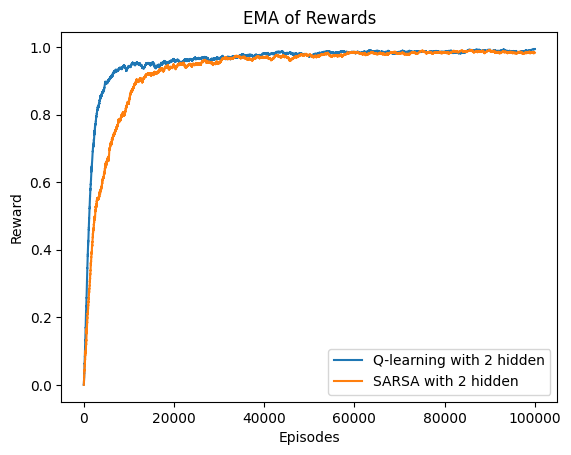

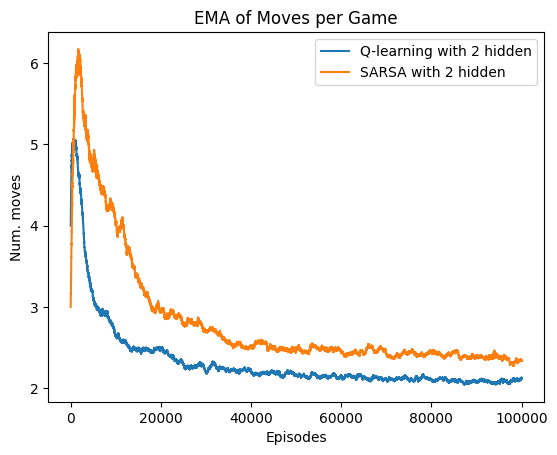

In [50]:
EMA_Reward_S2 = ema(Reward_cached_S2, alpha)
EMA_Moves_S2 = ema(Num_moves_cached_S2, alpha)
EMA_Reward_Q2 = ema(Reward_cached_Q2, alpha)
EMA_Moves_Q2 = ema(Num_moves_cached_Q2, alpha)



plt.plot(EMA_Reward_Q2, label='Q-learning with 2 hidden')
plt.plot(EMA_Reward_S2, label='SARSA with 2 hidden')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('EMA of Rewards')
plt.legend()  # Display the legend showing the labels
plt.savefig('figures/EMA_Rewards_Combined_2hid.png', dpi=500)
plt.show()

plt.plot(EMA_Moves_Q2, label='Q-learning with 2 hidden')
plt.plot(EMA_Moves_S2, label='SARSA with 2 hidden')
plt.xlabel('Episodes')
plt.ylabel('Num. moves')
plt.title('EMA of Moves per Game')
plt.legend()  # Display the legend showing the labels
plt.savefig('figures/EMA_Moves_Combined_2hid.png', dpi=500)
plt.show()



